# Dec 15, 2023: pca dimensionality reduction of time series

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product, combinations
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool

import ssm

from sklearn.decomposition import PCA
# networks
import networkx as nx
import ants
from nipype.interfaces import afni

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

231220-17:13:24,769 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

In [3]:
args.parcel_name = 'whole'
args.rois_folder = 'yale_172' # 'hadi_1445'
COLLECT_path = f'/home/govindas/mouse_dataset/voxel/all_file_collections'
BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi'
TS_path = f'{BASE_path}/{args.rois_folder}/roi_timeseries_txt_files/{args.parcel_name}'
RES_path = f'{BASE_path}/{args.rois_folder}/temp_states/{args.parcel_name}'
cmd = (
    f'mkdir -p {RES_path}'
)
os.system(cmd)

0

In [4]:
hadi_1445_img = (
    f'{os.environ["HOME"]}/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
    f'/warped_on_n162/{args.parcel_name}_parcels_warped_cm.nii.gz'
)
yale_172_img = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/172_parcels_RAS_cm.nii.gz'
)
parcels_img = ants.image_read(yale_172_img)
parcels = parcels_img.numpy()

hadi_1445_rois = (
    f'{os.environ["HOME"]}/mouse_dataset/allen_atlas_ccfv3/hadi/parcellation'
    f'/warped_on_n162/{args.parcel_name}_roi_labels.txt'
)
yale_172_rois = (
    f'{os.environ["HOME"]}/mouse_dataset' 
    f'/n162_parcellations/172_roi_labels.txt'
)
roi_labels = np.loadtxt(yale_172_rois)
roi_labels.shape

(172,)

In [5]:
args.num_subs = 10
args.num_sess = 3
args.num_rois = roi_labels.shape[0]
args.tot_time = 600 # total time points

main_sample = [
    [
        []
        for ses in range(args.num_sess)
    ]
    for sub in range(args.num_subs)
]
for file in os.listdir(TS_path):
    fs = file.split('_')
    if int(fs[2].split('-')[-1]) % 2 == 0: continue # skip even runs
    sub = int(fs[0].split('-')[-1][-2:])
    ses = int(fs[1].split('-')[-1])
    main_sample[sub-1][ses-1].append(file)

for sub in np.arange(1,args.num_subs+1):
    for ses in np.arange(1, args.num_sess+1):
        main_sample[sub-1][ses-1] = list(np.sort(main_sample[sub-1][ses-1]))

In [6]:
def get_frame_censor_mask(run):
    identity = '_'.join(run.split('_')[:-1])
    collections_file = [f for f in os.listdir(COLLECT_path) if identity in f][0]
    with open(f'{COLLECT_path}/{collections_file}', 'r') as f:
        frm_csr_file = f.readlines()[0][:-1]
    with open(frm_csr_file, 'r') as f:
        frm_csr =  np.array([(v[:-1]) == 'True' for v in f.readlines()[1:]])
    return frm_csr

In [7]:
ts_sample = deepcopy(main_sample)
ts_all, mask_all = [], []
for sub, ses in tqdm(product(range(args.num_subs), range(args.num_sess))):
    ts_runs, mask_runs = [], []
    for run in main_sample[sub][ses]:
        ts = np.loadtxt(f'{TS_path}/{run}')
        ts = stats.zscore(ts, axis=0, nan_policy='omit') # time x rois
        ts = np.nan_to_num(ts)
        mask = get_frame_censor_mask(run)
        ts_big = np.zeros((args.tot_time, args.num_rois))
        ts_big[mask, :] = ts
        mask = np.tile(mask[None, :].T, (1, args.num_rois)) # tot_time x rois
        
        ts_runs.append(ts_big)
        mask_runs.append(mask)
        ts_all.append(ts_big)
        mask_all.append(mask)
    ts_sample[sub][ses] = list(zip(ts_runs, mask_runs))

30it [00:00, 33.02it/s]


In [8]:
with open(f'{RES_path}/ts_sample.npy', 'wb') as f:
    pickle.dump(ts_sample, f)

---

In [9]:
# PCA
args.var = 0.25 # variance explained
ts_all_stk = np.vstack(ts_all)
try:
    with open(f'{RES_path}/pca_ts_v-{args.var}.pkl', 'rb') as f:
        [pca, ts_all_pca, mask_all_pca] = pickle.load(f)
        args.num_comps = ts_all_pca[0].shape[-1]
        print(args.num_comps)
        ts_all_stk_pca = np.vstack(ts_all_pca)
except:
    # find the suitable '# of components' to explain `args.var` variance in data
    pca = PCA(n_components=args.num_rois) 
    pca = pca.fit(ts_all_stk)
    c = np.cumsum(pca.explained_variance_ratio_)
    d = np.max(np.where(c <= args.var)[0])
    
    # fresh pca with found '# of components'
    pca = PCA(n_components=d)
    ts_all_stk_pca = pca.fit_transform(ts_all_stk)
    print(ts_all_stk_pca.shape)
    ts_all_pca = np.split(ts_all_stk_pca, len(ts_all))
    mask_all_pca = [mask[:, d] for mask in mask_all]
    
    with open(f'{RES_path}/pca_ts_v-{args.var}.pkl', 'wb') as f:
        pickle.dump([pca, ts_all_pca, mask_all_pca], f)
    
    args.num_comps = ts_all_pca[0].shape[-1]
    assert args.num_comps == d

9


---

In [10]:
args.N_iters = 25
args.transitions = 'standard'
args.observations = 'gaussian'
for args.num_states in range(2, 10):
    try:
        with open(
            (
                f'{RES_path}'
                f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
            ), 
            'rb'
        ) as f:
            hmm = pickle.load(f)
    except:
        print(f'D = {args.num_comps}, K = {args.num_states}')
        hmm = ssm.HMM(
            K=args.num_states,
            D=args.num_comps,
            transitions=args.transitions,
            observations=args.observations,
        )
        lls = hmm.fit(
            datas=ts_all_pca, 
            masks=mask_all_pca,
            method='em', 
            num_iters=args.N_iters, 
            init_method='kmeans',
        )
        with open(
            (
                f'{RES_path}'
                f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
            ), 
            'wb'
        ) as f:
            pickle.dump(hmm, f)
        plt.plot(lls)

---

In [11]:
args.num_states = 5
with open(
        (
            f'{RES_path}'
            f'/hmm_v-{args.var}_k-{args.num_states}_trns-{args.transitions}_obs-{args.observations}.pkl'
        ), 
        'rb'
    ) as f:
        hmm = pickle.load(f)

Text(0.5, 1.0, 'state transition probs.')

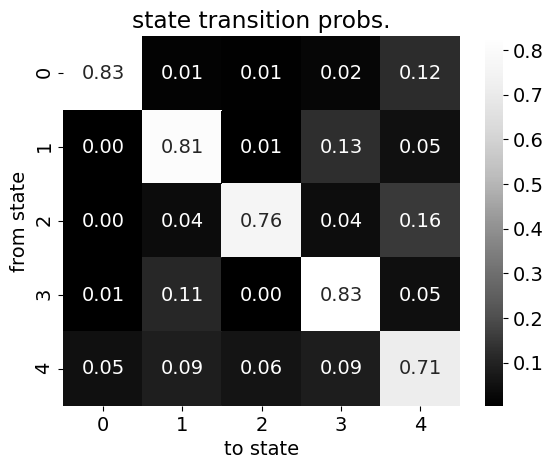

In [12]:
# state transiton matrix
sns.heatmap(hmm.transitions.transition_matrix, cmap='Greys_r', annot=True, fmt='.2f')
plt.xlabel('to state')
plt.ylabel('from state')
plt.title('state transition probs.')

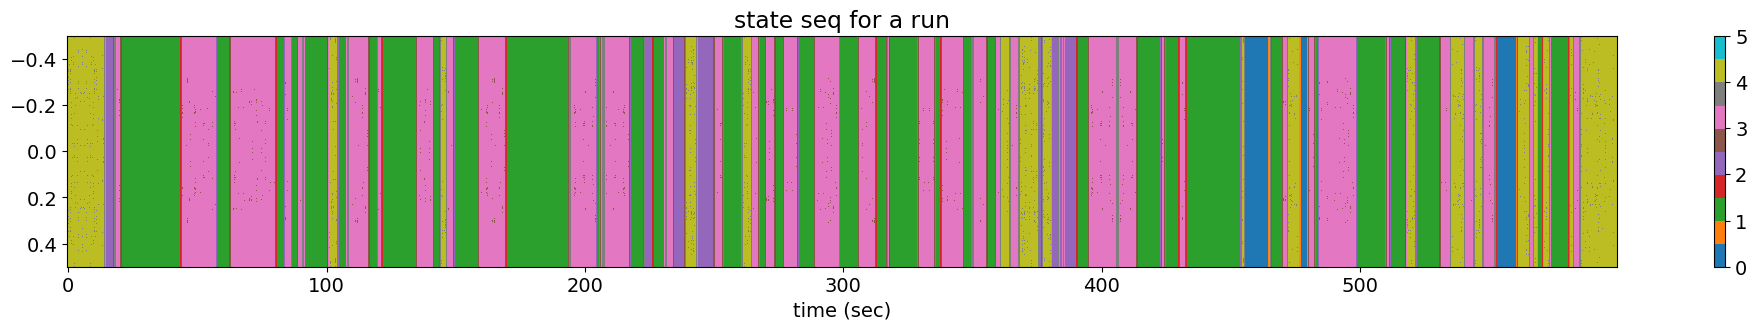

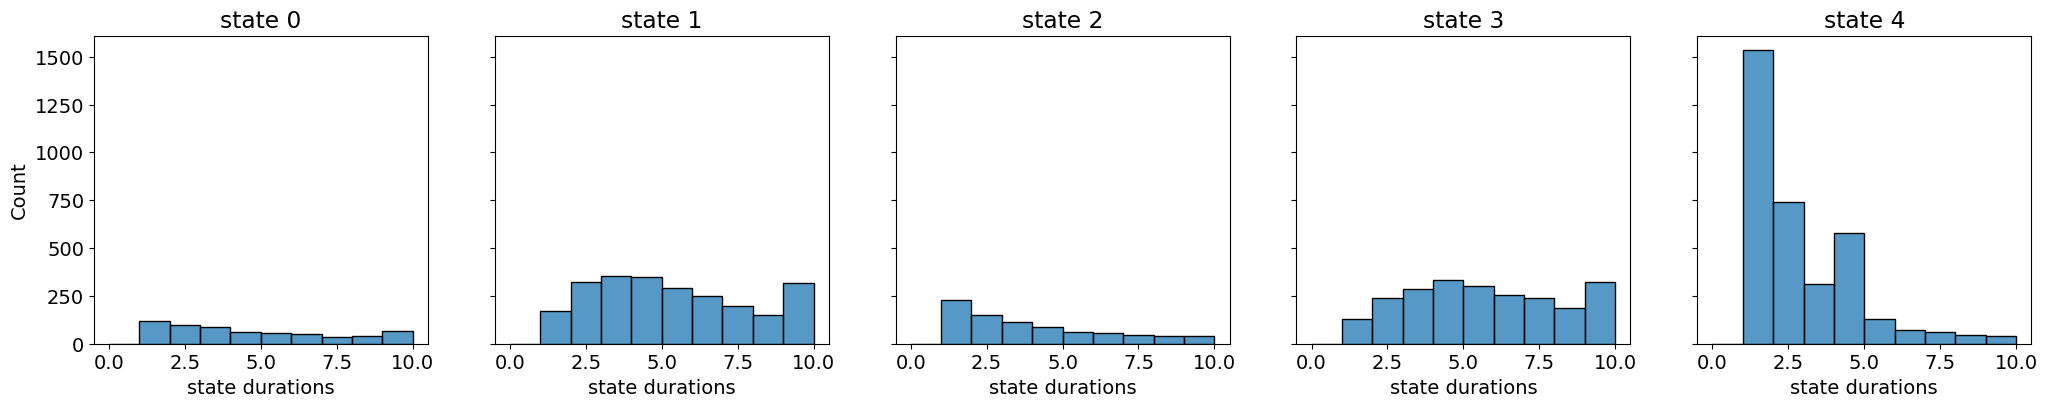

In [13]:
# state sequence
plt.figure(figsize=(25, 3))
plt.imshow(
    hmm.most_likely_states(ts_all_pca[27])[None, :], 
    aspect='auto',
    cmap='tab10',
    vmin=0, 
    vmax=args.num_states,
)
plt.colorbar()
plt.title('state seq for a run')
plt.xlabel('time (sec)')

# continuous durations
state_seq = hmm.most_likely_states(ts_all_stk_pca)
durs_stacked = [[] for _ in range(args.num_states)]
st_list, durs = ssm.util.rle(state_seq)
for s in range(args.num_states):
    durs_stacked[s] = durs[st_list == s]
    
nrows, ncols = int(args.num_states // 5), 5
nrows = nrows if nrows > 0 else 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
for idx_state in range(args.num_states):
    r, c = idx_state // 5,  idx_state % 5
    ax = axs[r, c] if args.num_states > 5 else axs[c]
    
    sns.histplot(durs_stacked[idx_state], stat='count', binwidth=1, binrange=[0, 10], ax=ax)
    ax.set(title=f'state {idx_state}', xlabel='state durations')

[Text(0.5, 1.0, 'mean life time')]

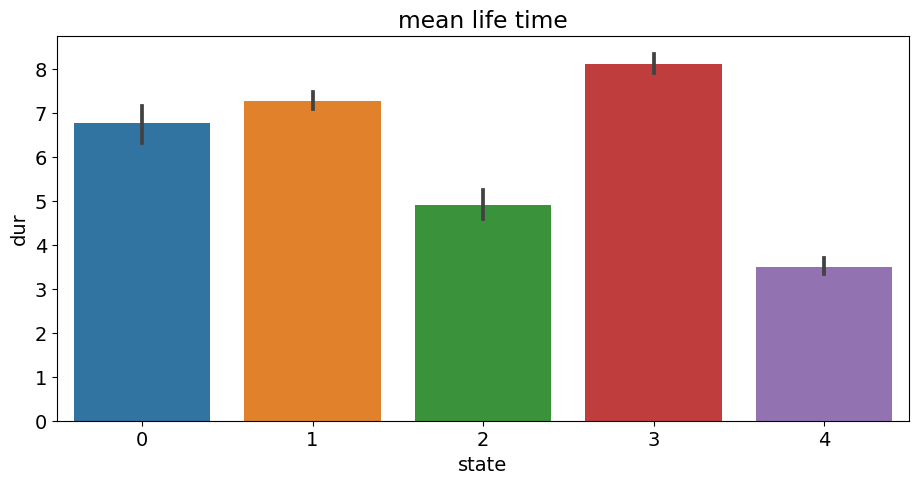

In [14]:
# mean lifetime
durs_stacked_df = pd.DataFrame({'dur':durs, 'state':st_list})
fig, axs = plt.subplots(1, 1, figsize=(11, 5), dpi=100)
ax = axs
sns.barplot(data=durs_stacked_df, x='state', y='dur', ax=ax,)
ax.set(title=f'mean life time')